In [5]:
import os
import re
import random
from datetime import date
import pandas as pd
import numpy as np
import cv2
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data as torch_data
from torchinfo import summary
import time
from skimage.transform import resize


import sklearn
from sklearn import model_selection as sk_model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import nibabel as nib
import matplotlib.pyplot as plt

from unet_down import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau

import seaborn as sns

In [16]:
#Set up Model
x = torch.randn(size=(1, 4,90,90,90), dtype=torch.float32)
batchsize_3d = 256*(x.shape[2]//16)*(x.shape[3]//16)*(x.shape[4]//16)
print(batchsize_3d)
input_shape = (90,90,90)

32000


In [17]:
from unet_down import UNet

model = UNet(in_channels=4,
             out_channels=2,
             n_blocks=4,
             input_shape = input_shape,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=3,
             hidden_channels=2048)


with torch.no_grad():
    out = model(x)

print(f'Out: {out}')

Out: tensor([[-0.1129, -0.1567]])


In [18]:
torch.cuda.empty_cache()
summary_1 = summary(model, input_size = (1, 4,90,90,90))
summary_1

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     --                        --
├─ModuleList: 1-1                        --                        --
│    └─DownBlock: 2-1                    [1, 32, 45, 45, 45]       --
│    │    └─Conv3d: 3-1                  [1, 32, 90, 90, 90]       3,488
│    │    └─ReLU: 3-2                    [1, 32, 90, 90, 90]       --
│    │    └─BatchNorm3d: 3-3             [1, 32, 90, 90, 90]       64
│    │    └─Conv3d: 3-4                  [1, 32, 90, 90, 90]       27,680
│    │    └─ReLU: 3-5                    [1, 32, 90, 90, 90]       --
│    │    └─BatchNorm3d: 3-6             [1, 32, 90, 90, 90]       64
│    │    └─MaxPool3d: 3-7               [1, 32, 45, 45, 45]       --
│    └─DownBlock: 2-2                    [1, 64, 22, 22, 22]       --
│    │    └─Conv3d: 3-8                  [1, 64, 45, 45, 45]       55,360
│    │    └─ReLU: 3-9                    [1, 64, 45, 45, 45]       --
│   

In [2]:
raw_data_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_Prep_Segmentation'
masks_data_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_Masks_Train'
label_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/train_labels.csv'

mri_types = ['flair','t1','t1ce','t2']

In [3]:
def get_full_df(label_path):
    train_df = pd.read_csv(label_path,dtype = {'BraTS21ID':'str','MGMT_value':'int'})
    index_name = train_df[(train_df['BraTS21ID'] == '00109') | (train_df['BraTS21ID'] == '00123') | (train_df['BraTS21ID'] == '00709')].index
    train_df = train_df.drop(index_name).reset_index(drop=True)
    
    return train_df

def load_raw_voxel(patient_id,mri_type):
    # Normalize voxel volume to 0~255
    voxels = nib.load(f'{raw_data_path}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_{mri_type}.nii.gz').get_fdata().astype('float')
    _min = voxels.min()
    _max = voxels.max()
    new_voxels = (voxels - _min) / (_max-_min) * 255.0
    return new_voxels

def load_mask(patient_id):
    return nib.load(f'{masks_data_path }/BraTS2021_{patient_id}.nii.gz').get_fdata().astype('float')

#00006

In [453]:
test_ID = '00006'
print(test_ID)
test_voxel = load_raw_voxel(test_ID,mri_types[3])
test_mask = load_mask(test_ID)

# Replace mark 2 and 4 to 1 
mask_WT = test_mask.copy()
mask_WT[(mask_WT == 2) | (mask_WT == 4)] = 1

test_tumor = mask_WT*test_voxel

00006


Text(0.5, 1.0, 'Segmentation Label')

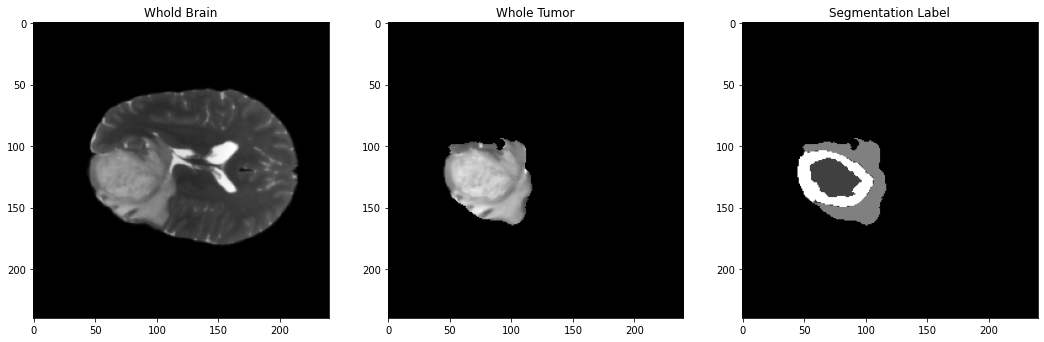

In [454]:
index = 85
fig, axes = plt.subplots(1,3, figsize=(18, 12))

fig.subplots_adjust(top=0.95)

axes[0].imshow(test_voxel[:,:,index],cmap = 'gray')
axes[0].set_title('Whold Brain', fontsize=12)
axes[0].set_aspect(1)

axes[1].imshow(test_tumor[:,:,index],cmap = 'gray')
axes[1].set_title('Whole Tumor', fontsize=12)

axes[2].imshow(test_mask[:,:,index],cmap = 'gray')
axes[2].set_title('Segmentation Label', fontsize=12)

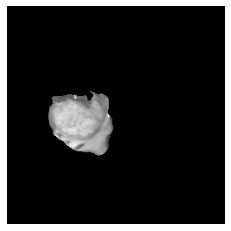

In [469]:
plt.axis('off')
mask_t = test_mask.copy()
mask_t[(mask_t ==2) | (mask_t == 4)] = 1
t_tumor = mask_t*test_voxel
plt.imshow(t_tumor[:,:,index],cmap = 'gray')
plt.savefig('../Pre-processing/saved_images/00006_WT.png', bbox_inches='tight', transparent=True,pad_inches=0)

In [147]:
def non_0_voxel_mask(voxel,mask):
    length = mask.shape[2]
    start_id = 0
    end_id = length-1

    # From begining to find start index
    for i in range(length):
        if np.max(mask[:,:,i]) != 0:
            start_id = i
            break

    # From final to find end index
    for i in range(length-1,-1,-1):
        if np.max(mask[:,:,i]) != 0:
            end_id = i
            break
    non_0_indexs = slice(start_id,end_id+1)
    
    return voxel[:,:,non_0_indexs],mask[:,:,non_0_indexs]

def find_largest_countours(contours):
    max_cnt = max(contours, key=lambda cnt: cv2.contourArea(cnt))
    return max_cnt


def get_area_over_image_ratio(image, mask):
    _, image_thresh = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    
    # image_contours, _ = cv2.findContours(image_thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    image_contours, _ = cv2.findContours(image=image_thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    if not image_contours:
        return 0
    max_image_cnt = find_largest_countours(image_contours)
    
    _, mask_thresh = cv2.threshold(mask,0.5,1,cv2.THRESH_BINARY)
    mask_contours, _ = cv2.findContours(image=mask_thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    count_n_mask_contours = len(mask_contours)
    if(count_n_mask_contours == 0):
        return 0
    max_mask_cnt = find_largest_countours(mask_contours)
    area_mask_over_image_ratio = cv2.contourArea(max_mask_cnt) / cv2.contourArea(max_image_cnt)
    return area_mask_over_image_ratio 

In [17]:
# def construct_target_volume(scan_id,mri_type,ratio=0.02):
#     raw_voxel = load_raw_voxel(scan_id,mri_type)
#     mask = load_mask(scan_id)
    
#     non_0_voxel,non_0_mask = non_0_voxel_mask(raw_voxel,mask)
    
#     mask_WT = non_0_mask.copy()
#     mask_WT[(mask_WT == 2) | (mask_WT == 4)] = 1
#     voxel_WT = mask_WT*non_0_voxel
    
#     length = voxel_WT.shape[2]
    
#     first_image = True
#     for i in range(length):
#         if first_image:
#             if has_good_features(non_0_voxel[:,:,i].astype('uint8'), voxel_WT[:,:,i].astype('uint8'),
#                                                             area_mask_over_image_min_ratio=ratio):
#                 previous_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
#                 first_image = False
#         else:
#             if has_good_features(non_0_voxel[:,:,i].astype('uint8'), voxel_WT[:,:,i].astype('uint8'),
#                                                             area_mask_over_image_min_ratio=ratio):
#                 new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
#                 previous_images = np.dstack((previous_images,new_images))
        
#     if first_image:
#         print(f'ID:{scan_id} has no good feature')
#         return None
#     else:
#         return previous_images

In [35]:
# def construct_target_volume(scan_id,mri_type,scale_size=90):
#     raw_voxel = load_raw_voxel(scan_id,mri_type)
#     mask = load_mask(scan_id)
    
#     non_0_voxel,non_0_mask = non_0_voxel_mask(raw_voxel,mask)
    
#     mask_WT = non_0_mask.copy()
#     mask_WT[(mask_WT == 2) | (mask_WT == 4)] = 1
#     voxel_WT = mask_WT*non_0_voxel
    
#     length = voxel_WT.shape[2]
#     #------------------------------------Warning To-do ------------------
#     if scan_id =='00651' and mri_type =='t1ce':
#         max_slice_index = length//2
#         half_len = scale_size//6

#         start_ind = max_slice_index - half_len
#         end_ind = max_slice_index + half_len-1
#         if end_ind > (length-1):
#             diff = end_ind - (length-1)
#             start_ind = start_ind-diff
#             end_ind = end_ind -diff

#         constructed_voxel= np.stack([non_0_voxel[:,:,start_ind],mask_WT[:,:,start_ind],non_0_mask[:,:,start_ind]],axis=-1)

#         for i in range(start_ind+1,end_ind+1):
#             new_images = np.stack([non_0_voxel[:,:,i],mask_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
#             constructed_voxel = np.dstack((constructed_voxel,new_images))
#         return constructed_voxel
#     #---------------------------------------------------------------------------
    
#     if length<(scale_size/3):
#         constructed_voxel= np.stack([non_0_voxel[:,:,0],mask_WT[:,:,0],non_0_mask[:,:,0]],axis=-1)
#         for i in range(1,length):
#             new_images = np.stack([non_0_voxel[:,:,i],mask_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
#             constructed_voxel = np.dstack((constructed_voxel,new_images))
        
        
#         fixed_voxel = np.zeros((240,240,scale_size))
#         real_length = constructed_voxel.shape[2]
        
#         start = (scale_size-real_length)//2
#         end = start+real_length
#         fixed_voxel[:,:,start:end] = constructed_voxel
        
#         return fixed_voxel
#     else:
#         max_ratio = 0
#         max_slice_index = length//2
#         for i in range(length):
#             current_ratio = get_area_over_image_ratio(non_0_voxel[:,:,i].astype('uint8'), mask_WT[:,:,i].astype('uint8'))
#             if current_ratio>max_ratio:
#                 max_ratio = current_ratio
#                 max_slice_index = i

#         half_len = scale_size//6

#         start_ind = max_slice_index - half_len
#         end_ind = max_slice_index + half_len-1
#         if end_ind > (length-1):
#             diff = end_ind - (length-1)
#             start_ind = start_ind-diff
#             end_ind = end_ind -diff

#         constructed_voxel= np.stack([non_0_voxel[:,:,start_ind],mask_WT[:,:,start_ind],non_0_mask[:,:,start_ind]],axis=-1)

#         for i in range(start_ind+1,end_ind+1):
#             new_images = np.stack([non_0_voxel[:,:,i],mask_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
#             constructed_voxel = np.dstack((constructed_voxel,new_images))
#         return constructed_voxel

In [ ]:
def construct_target_volume(scan_id,mri_type,scale_size=90):
    raw_voxel = load_raw_voxel(scan_id,mri_type)
    mask = load_mask(scan_id)
    
    non_0_voxel,non_0_mask = non_0_voxel_mask(raw_voxel,mask)
    
    mask_WT = non_0_mask.copy()
    mask_WT[(mask_WT == 2) | (mask_WT == 4)] = 1
    voxel_WT = mask_WT*non_0_voxel
    
    length = voxel_WT.shape[2]
    #------------------------------------Warning To-do ------------------
    if scan_id =='00651' and mri_type =='t1ce':
        max_slice_index = 44
        half_len = scale_size//6

        start_ind = max_slice_index - half_len
        end_ind = max_slice_index + half_len-1
        if end_ind > (length-1):
            diff = end_ind - (length-1)
            start_ind = start_ind-diff
            end_ind = end_ind -diff

        constructed_voxel= np.stack([non_0_voxel[:,:,start_ind],voxel_WT[:,:,start_ind],non_0_mask[:,:,start_ind]],axis=-1)

        for i in range(start_ind+1,end_ind+1):
            new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
            constructed_voxel = np.dstack((constructed_voxel,new_images))
        
        return constructed_voxel
    #---------------------------------------------------------------------------
    
    if length<(scale_size/3):
        constructed_voxel= np.stack([non_0_voxel[:,:,0],voxel_WT[:,:,0],non_0_mask[:,:,0]],axis=-1)
        for i in range(1,length):
            new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
            constructed_voxel = np.dstack((constructed_voxel,new_images))
        
        
        fixed_voxel = np.zeros((240,240,scale_size))
        real_length = constructed_voxel.shape[2]
        
        start = (scale_size-real_length)//2
        end = start+real_length
        fixed_voxel[:,:,start:end] = constructed_voxel
        
        return fixed_voxel
    else:
        max_ratio = 0
        max_slice_index = length//2
        for i in range(length):
            current_ratio = get_area_over_image_ratio(non_0_voxel[:,:,i].astype('uint8'), mask_WT[:,:,i].astype('uint8'))
            if current_ratio>max_ratio:
                max_ratio = current_ratio
                max_slice_index = i

        half_len = scale_size//6

        start_ind = max_slice_index - half_len
        end_ind = max_slice_index + half_len-1
        if end_ind > (length-1):
            diff = end_ind - (length-1)
            start_ind = start_ind-diff
            end_ind = end_ind -diff

        constructed_voxel= np.stack([non_0_voxel[:,:,start_ind],voxel_WT[:,:,start_ind],non_0_mask[:,:,start_ind]],axis=-1)

        for i in range(start_ind+1,end_ind+1):
            new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],non_0_mask[:,:,i]],axis=-1)
            constructed_voxel = np.dstack((constructed_voxel,new_images))
        return constructed_voxel

In [167]:
#-----------------------WB(0-255)+WT(0-255)+Subregion(0-100) ------------------
def get_percent_volume(raw_mask):
    mask_per = raw_mask.copy()
    unique, counts = np.unique(raw_mask, return_counts=True)
    unique = unique[unique!=0].astype('int')
    
    mask_count = dict(zip(unique, counts))
    total_mask = 0
    
    for mask in unique:
        total_mask += mask_count[mask]
    
    for mask in unique:
        mask_per[mask_per == mask] =  (mask_count[mask]/total_mask)*100
    
    return mask_per

def construct_target_volume(scan_id,mri_type,scale_size=90):
    raw_voxel = load_raw_voxel(scan_id,mri_type)
    mask = load_mask(scan_id)
    
    non_0_voxel,non_0_mask = non_0_voxel_mask(raw_voxel,mask)
    
    mask_WT = non_0_mask.copy()
    mask_WT[(mask_WT == 2) | (mask_WT == 4)] = 1
    voxel_WT = mask_WT*non_0_voxel
    
    mask_per = get_percent_volume(non_0_mask)
    
    length = voxel_WT.shape[2]
    #------------------------------------Warning To-do ------------------
    if scan_id =='00651' and mri_type =='t1ce':
        max_slice_index = 44
        half_len = scale_size//6

        start_ind = max_slice_index - half_len
        end_ind = max_slice_index + half_len-1
        if end_ind > (length-1):
            diff = end_ind - (length-1)
            start_ind = start_ind-diff
            end_ind = end_ind -diff

        constructed_voxel= np.stack([non_0_voxel[:,:,start_ind],voxel_WT[:,:,start_ind],mask_per[:,:,start_ind]],axis=-1)

        for i in range(start_ind+1,end_ind+1):
            new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],mask_per[:,:,i]],axis=-1)
            constructed_voxel = np.dstack((constructed_voxel,new_images))
        
        return constructed_voxel
    #---------------------------------------------------------------------------
    
    if length<(scale_size/3):
        constructed_voxel= np.stack([non_0_voxel[:,:,0],voxel_WT[:,:,0],mask_per[:,:,0]],axis=-1)
        for i in range(1,length):
            new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],mask_per[:,:,i]],axis=-1)
            constructed_voxel = np.dstack((constructed_voxel,new_images))
        
        
        fixed_voxel = np.zeros((240,240,scale_size))
        real_length = constructed_voxel.shape[2]
        
        start = (scale_size-real_length)//2
        end = start+real_length
        fixed_voxel[:,:,start:end] = constructed_voxel
        
        return fixed_voxel
    else:
        max_ratio = 0
        max_slice_index = length//2
        for i in range(length):
            current_ratio = get_area_over_image_ratio(non_0_voxel[:,:,i].astype('uint8'), mask_WT[:,:,i].astype('uint8'))
            if current_ratio>max_ratio:
                max_ratio = current_ratio
                max_slice_index = i

        half_len = scale_size//6

        start_ind = max_slice_index - half_len
        end_ind = max_slice_index + half_len-1
        if end_ind > (length-1):
            diff = end_ind - (length-1)
            start_ind = start_ind-diff
            end_ind = end_ind -diff

        constructed_voxel= np.stack([non_0_voxel[:,:,start_ind],voxel_WT[:,:,start_ind],mask_per[:,:,start_ind]],axis=-1)

        for i in range(start_ind+1,end_ind+1):
            new_images = np.stack([non_0_voxel[:,:,i],voxel_WT[:,:,i],mask_per[:,:,i]],axis=-1)
            constructed_voxel = np.dstack((constructed_voxel,new_images))
        return constructed_voxel

### Rescale to fixed size

In [381]:
INPUT_SIZE = (90,90,90)
MRI_TYPES = ['flair','t1','t1ce','t2']
SAVE_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_WB_96_96_62'
LABEL_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/train_labels.csv'
MASK_RE_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Mask_90_90_90'

"""
#---------------------- Raw Mask ------------------
def rescale_mask(scan_id, scale_factor=90):
    raw_voxel = load_mask(scan_id)

    fixed_data = resize(raw_voxel,INPUT_SIZE,anti_aliasing=True)
    fixed_data[fixed_data != 0] = 1
    
    return fixed_data
"""

#---------------------- Raw WB(0-255) ------------------
def rescale_volume(scan_id,mri_type,scale_factor=90):
    raw_voxel = load_raw_voxel(scan_id,mri_type)

    
    fixed_data = resize(raw_voxel,(96,96,62),preserve_range=True,anti_aliasing=True)
    fixed_data[fixed_data < 1e-10 ] = 0
    
    
    return fixed_data


#---------------------- Raw WT(0-255) ------------------
# def rescale_volume(scan_id,mri_type,scale_size=90):
#     raw_voxel = load_raw_voxel(scan_id,mri_type)
#     mask_WT = load_mask(scan_id)
    
    
#     mask_WT[(mask_WT == 2) | (mask_WT == 4)] = 1
#     voxel_WT = mask_WT*raw_voxel
    
#     fixed_data = resize(voxel_WT,INPUT_SIZE,preserve_range=True,anti_aliasing=True)
#     fixed_data[fixed_data < 1e-10 ] = 0
    
    
#     return fixed_data

#---------------------- TC (0-255) ------------------
# def rescale_volume(scan_id,mri_type,scale_size=90):
#     raw_voxel = load_raw_voxel(scan_id,mri_type)
#     mask_WT = load_mask(scan_id)
    
    
#      # Tumor Core
#     mask_TC = mask_WT.copy()
#     mask_TC[mask_TC == 2] = 0
#     mask_TC[mask_TC == 4] = 1
#     voxel_TC = mask_TC*raw_voxel
    
#     fixed_data = resize(voxel_TC,INPUT_SIZE,preserve_range=True,anti_aliasing=True)
#     fixed_data[fixed_data < 1e-10 ] = 0
    
    
#     return fixed_data

#---------------------- ET (0-255) ------------------
# def rescale_volume(scan_id,mri_type,scale_size=90):
#     raw_voxel = load_raw_voxel(scan_id,mri_type)
#     mask_WT = load_mask(scan_id)
    
#     # Enhancing Tumor
#     mask_ET = mask_WT.copy()
#     mask_ET[(mask_ET == 2) | (mask_ET == 1)] = 0
#     mask_ET[mask_ET==4] = 1
#     voxel_ET = mask_ET*raw_voxel
    
#     fixed_data = resize(voxel_ET,INPUT_SIZE,preserve_range=True,anti_aliasing=True)
#     fixed_data[fixed_data < 1e-10 ] = 0
    
    
#     return fixed_data
    
def prepare_rescaleed_data(df,save_path,scale_size=90):
    start = time.time()
    for num, scan_id in enumerate(df['BraTS21ID'].values,start = 1):
        for mri_type in MRI_TYPES:
            rescale_data = rescale_volume(scan_id,mri_type,scale_size)
            
            # Save data
            save_folder = f'BraTS2021_{scan_id}'
            new_save_path = os.path.join(save_path, save_folder)
            if save_folder not in os.listdir(save_path):
                    os.mkdir(new_save_path)
            img = nib.Nifti1Image(rescale_data, np.eye(4))  # Save axis for data (just identity)

            img.header.get_xyzt_units()
            img.to_filename(os.path.join(new_save_path,f'BraTS2021_{scan_id}_{mri_type}.nii.gz'))  # Save as NiBabel file
            
        print(f'{scan_id}: Done! Average Time:{(time.time()-start)/num:.2f}s',end='\r')
            
    print(f'\nData Preraration completed in {int(time.time()-start)}s')



def prepare_rescaleed_mask(df,save_path,scale_size=90):
    start = time.time()
    for num, scan_id in enumerate(df['BraTS21ID'].values,start = 1):
        rescale_data = rescale_mask(scan_id,scale_size)
        # Save data
        img = nib.Nifti1Image(rescale_data, np.eye(4))  # Save axis for data (just identity)

        img.header.get_xyzt_units()
        img.to_filename(os.path.join(save_path,f'BraTS2021_{scan_id}.nii.gz'))  # Save as NiBabel file
            
        print(f'{scan_id}: Done! Average Time:{(time.time()-start)/num:.2f}s',end='\r')
            
    print(f'\nData Preraration completed in {int(time.time()-start)}s')

(96, 96, 62)


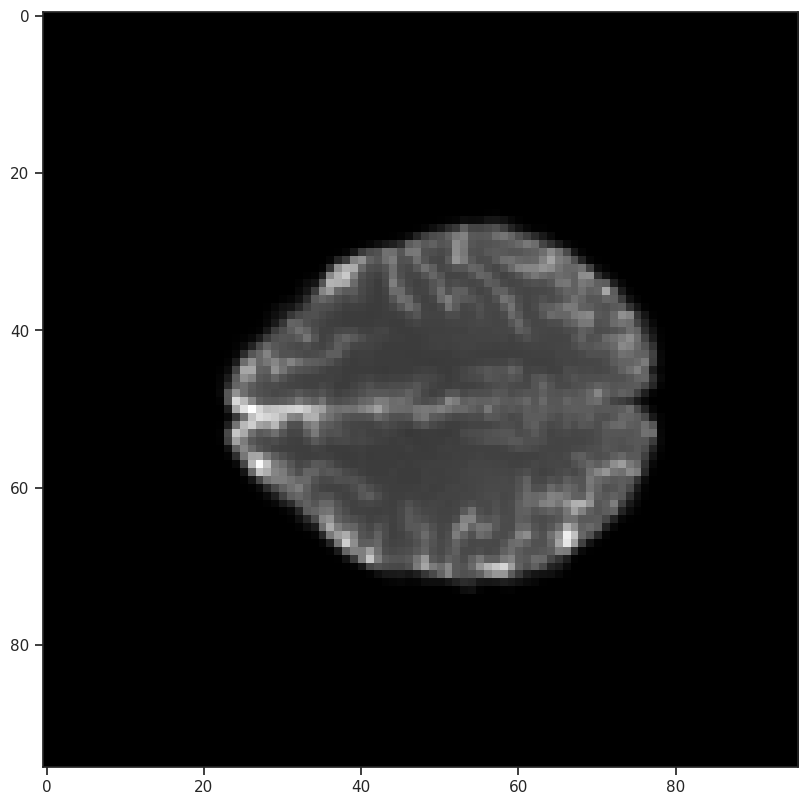

In [376]:
test =  rescale_volume('00000',MRI_TYPES[3])
print(test.shape)
plt.imshow(test[:,:,45],cmap='gray')

In [378]:
full_df = get_full_df(LABEL_PATH)
print(full_df.shape)
full_df.head()

(582, 2)


,BraTS21ID,MGMT_value
0,00000,1
1,00002,1
2,00003,0
3,00005,1
4,00006,1


In [380]:
prepare_rescaleed_data(full_df,SAVE_PATH)

(90, 90, 90)


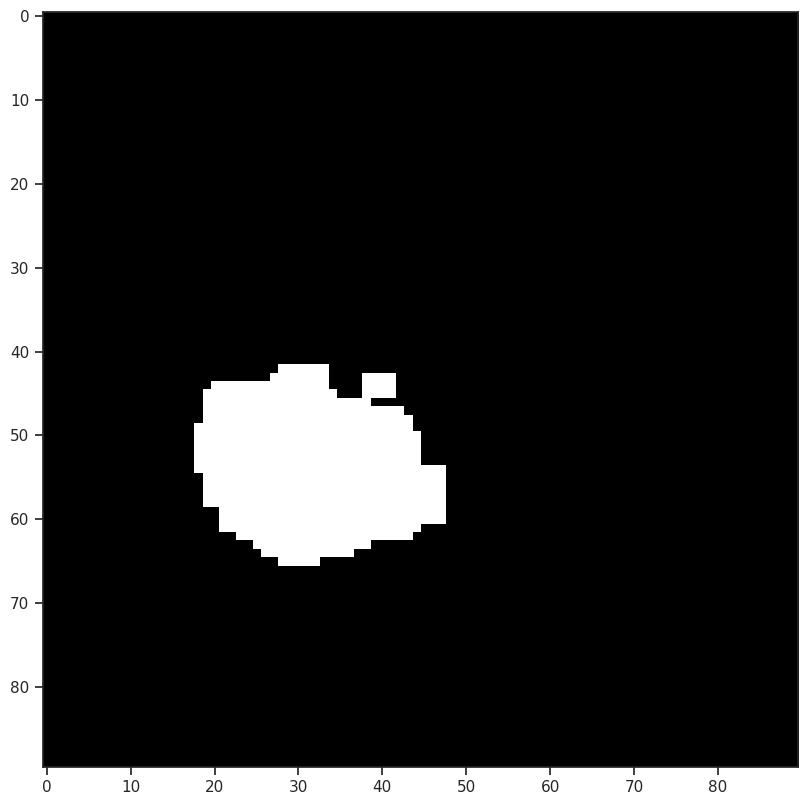

In [368]:
test =  rescale_mask('00000')
print(test.shape)
plt.imshow(test[:,:,45],cmap='gray')

In [373]:
prepare_rescaleed_mask(full_df,MASK_RE_PATH)

01010: Done! Average Time:0.32s
Data Preraration completed in 183s


### Construct for Trainging

In [325]:
WB_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_WB_90_90_90'
WT_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_WT_90_90_90'
TC_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_TC_90_90_90'
ET_PATH = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_ET_90_90_90'

def non_0_voxel(voxel):
    length = voxel.shape[2]
    start_id = 0
    end_id = length-1

    # From begining to find start index
    for i in range(length):
        if np.max(voxel[:,:,i]) != 0:
            start_id = i
            break

    # From final to find end index
    for i in range(length-1,-1,-1):
        if np.max(voxel[:,:,i]) != 0:
            end_id = i
            break
    non_0_indexs = slice(start_id,end_id+1)
    
    return non_0_indexs 

def construct_target_volume(scan_id,mri_type,scale_size=260):
    voxel_WB = nib.load(f'{WB_PATH}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_{mri_type}.nii.gz').get_fdata().astype('float')
    voxel_WT = nib.load(f'{WT_PATH}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_{mri_type}.nii.gz').get_fdata().astype('float')
    voxel_TC = nib.load(f'{TC_PATH}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_{mri_type}.nii.gz').get_fdata().astype('float')
    voxel_ET = nib.load(f'{ET_PATH}/BraTS2021_{scan_id}/BraTS2021_{scan_id}_{mri_type}.nii.gz').get_fdata().astype('float')
    
    voxel_WB[voxel_WB < 1e-1 ] = 0
    voxel_WT[voxel_WT < 1e-1] = 0
    voxel_TC[voxel_ET < 1e-1 ] = 0
    voxel_ET[voxel_TC < 1e-1] = 0
    
    non_0_slice = non_0_voxel(voxel_WB)
    
    non_0_WB = voxel_WB[:,:,non_0_slice]
    non_0_WT = voxel_WT[:,:,non_0_slice]
    non_0_TC = voxel_TC[:,:,non_0_slice]
    non_0_ET = voxel_ET[:,:,non_0_slice]
    
    split_length = scale_size//4
    diff = split_length-non_0_WB.shape[2]
    if diff<0:
        diff = abs(diff)
        div, mod = divmod(diff,2)
        start = div+mod-1
        end = non_0_WB.shape[2]-div-1

        constructed_voxel = np.dstack((non_0_WB[:,:,slice(start,end)],non_0_WT[:,:,slice(start,end)],non_0_TC[:,:,slice(start,end)],non_0_ET[:,:,slice(start,end)]))
    else:
        div, mod = divmod(diff,2)
        before = div+mod
        after = div

        fixed_WB = np.pad(non_0_WB,((0,0),(0,0),(before,after)))
        fixed_WT = np.pad(non_0_WT,((0,0),(0,0),(before,after)))
        fixed_TC = np.pad(non_0_WB,((0,0),(0,0),(before,after)))
        fixed_ET = np.pad(non_0_WT,((0,0),(0,0),(before,after)))

        constructed_voxel = np.dstack((fixed_WB,fixed_WT,fixed_TC,fixed_ET))
    return constructed_voxel

(90, 90, 260)


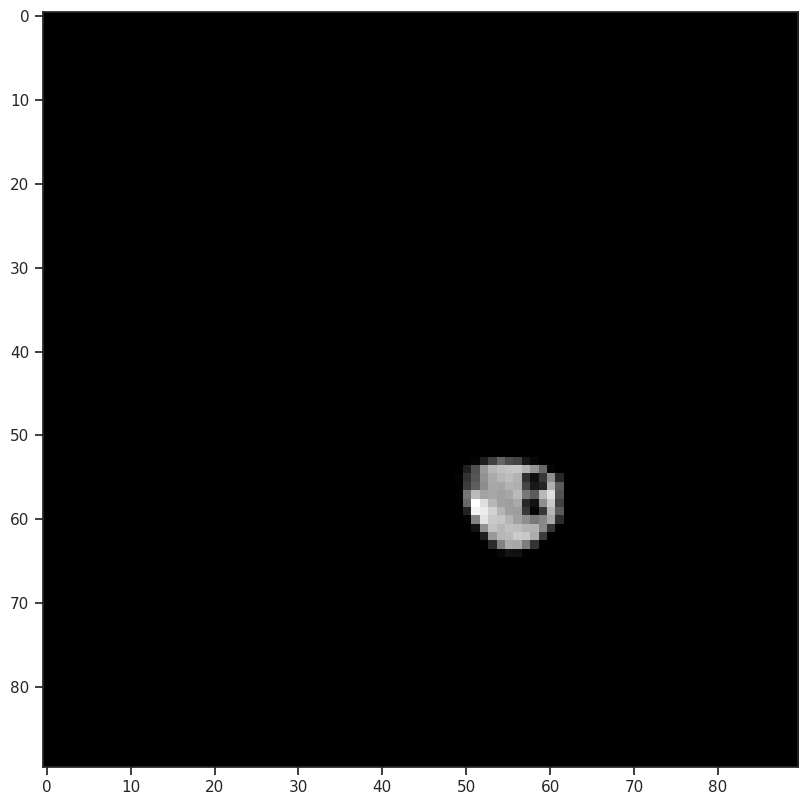

In [335]:
load_test = construct_target_volume('00519',MRI_TYPES[1])
print(load_test.shape)
plt.imshow(load_test[:,:,220],cmap='gray')

In [287]:
def non_0_voxel(voxel):
    length = voxel.shape[2]
    start_id = 0
    end_id = length-1

    # From begining to find start index
    for i in range(length):
        if np.max(voxel[:,:,i]) != 0:
            start_id = i
            break

    # From final to find end index
    for i in range(length-1,-1,-1):
        if np.max(voxel[:,:,i]) != 0:
            end_id = i
            break
    non_0_indexs = slice(start_id,end_id+1)
    
    return voxel[:,:,non_0_indexs]


def max_volume_length(df):
    start = time.time()
    length_list=[]
    for scan_id in df['BraTS21ID'].values:
        voxel = nib.load(f'/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_WB_90_90_90/BraTS2021_{scan_id}/BraTS2021_{scan_id}_t1ce.nii.gz').get_fdata().astype('float')
        data = non_0_voxel(voxel)
        length_list.append(data.shape[2])
                
    print(f'Algorithm completed in {int(time.time()-start)}s')
    return length_list

In [288]:
length_list = max_volume_length(full_df)

Algorithm completed in 14s


In [289]:
np.median(length_list)

57.0

In [284]:
a,b = np.unique(length_list,return_counts = True)

<AxesSubplot:xlabel='Length', ylabel='Count'>

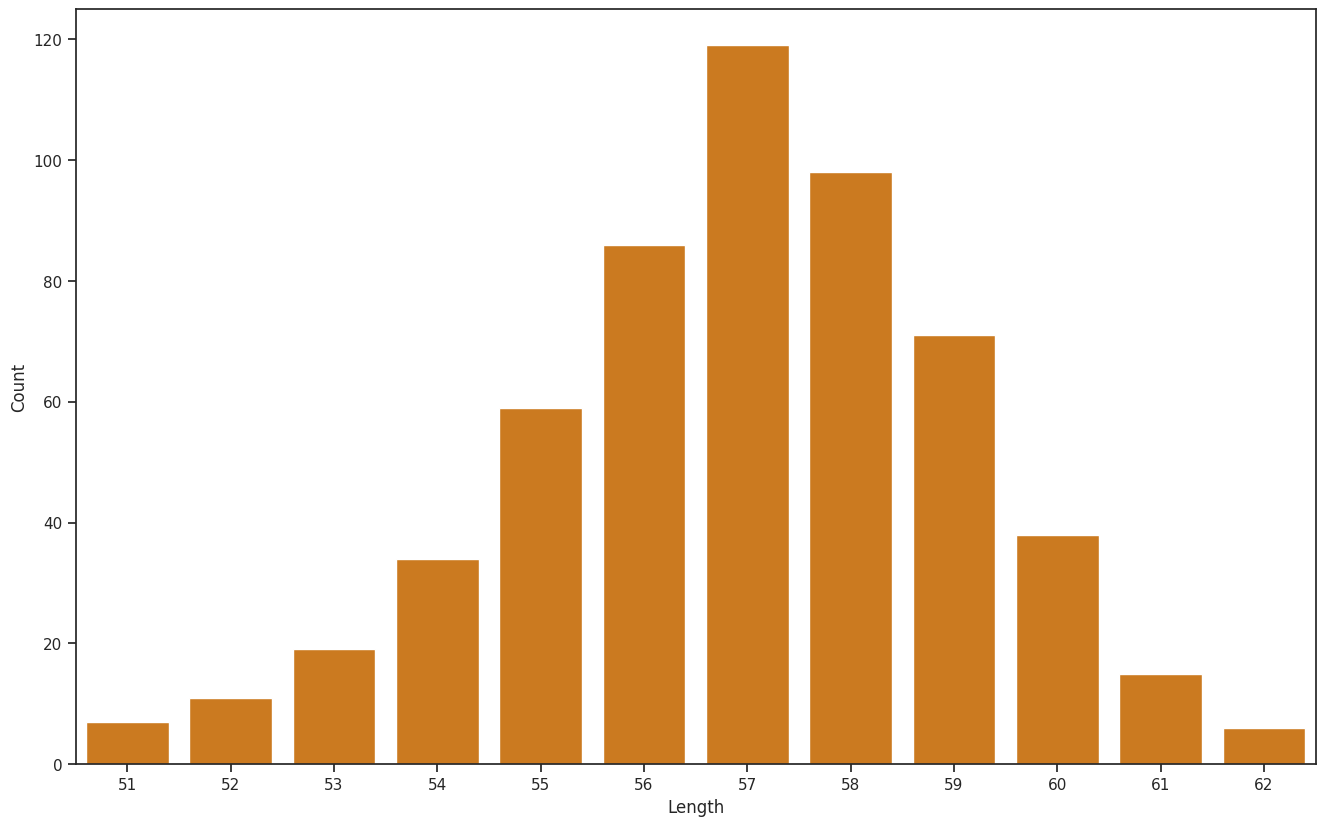

In [290]:
values, counts = np.unique(length_list, return_counts=True)


sns.set(rc={"figure.dpi":100, 'figure.figsize':(16,10)})
sns.set_style("ticks")

df_l = {'Length':values,'Count': counts}
df_l = pd.DataFrame(df_l)

sns.barplot(data=df_l[df_l.Count>=5], x="Length",y='Count', color='#e77b03')